In [ ]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets
from ipywidgets import *
from IPython.display import display
import IPython
import pandas as pd
import matplotlib
# from mplfinance import candlestick_ohlc
import mplfinance as mpf
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec

import numpy as np

from os.path import exists

from datetime import datetime
import talib
import pandas_ta as ta
# from talib.abstract import *
from math import *
from collections import OrderedDict
# import vectorbt as vbt    
import json
%matplotlib inline
from decimal import *
getcontext().prec = 6

from dotmap import DotMap

import seaborn as sns
# Apply the default theme
sns.set_theme()


matplotlib.rcParams.update({'font.size': 3, 'lines.linewidth': 0.5, 'figure.dpi': 300})


In [ ]:
def ffill_missing(df, tframe):
  freq = pd.Timedelta(tframe)
  td_since_last = df.date.diff()
  missing = td_since_last[td_since_last != freq].tail(-1) .to_dict()
  df = pd.concat([df, *[pd.DataFrame(index=pd.date_range(start=k-v+freq, end=k-freq, freq=freq)) for k,v in missing.items()]])
  df.sort_index(inplace=True)
  df.ffill(inplace=True)
  return df

def load_json_candles(fname):
  df = pd.read_json(fname)
  df.columns = ['ts', 'o', 'h', 'l', 'c', 'v']

  df['date'] = pd.to_datetime(df['ts'], unit='ms', utc=False)
  df.set_index(pd.DatetimeIndex(df["date"]), inplace=True, drop=True)
  df.sort_index(inplace=True)
  return df


In [626]:
symbol = 'ALGO_USDT'
tframe_H = '4h'
tframe_L = '15m'
data_folder = './freq-user-data/data/binance/'
df_H = load_json_candles(f'{data_folder}/{symbol}-{tframe_H}.json')
df_L = load_json_candles(f'{data_folder}/{symbol}-{tframe_L}.json')
df_H = ffill_missing(df_H, tframe_H)
df_L = ffill_missing(df_L, tframe_L)

In [627]:

# df.ffill(inplace=True)
# df_L.loc['2021-03-06 01:30:00': '2021-03-06 03:30:00', ['date', 'o', 'h', 'l', 'c']]

In [ ]:
def add_atr(df, periods=14):
  high_low = df['h'] - df['l']
  high_close = np.abs(df['h'] - df['c'].shift())
  low_close = np.abs(df['l'] - df['c'].shift())
  ranges = pd.concat([high_low, high_close, low_close], axis=1)
  true_range = np.max(ranges, axis=1)
  atr = true_range.rolling(periods).sum()/periods
  df['tr'] = true_range
  df['atr'] = atr
  df['tr_N'] = true_range / df.c * 100.
  df['atr_N'] = atr / df.c * 100.
  return df

def add_stoch(df, k_period=14, d_period=3):
  # Adds a "n_high" column with max value of previous 14 periods
  df['n_high'] = df['h'].rolling(k_period).max()
  # Adds an "n_low" column with min value of previous 14 periods
  df['n_low'] = df['l'].rolling(k_period).min()
  # Uses the min/max values to calculate the %k (as a percentage)
  df['stoch_k'] = (df['c'] - df['n_low']) * 100 / (df['n_high'] - df['n_low'])
  # Uses the %k to calculates a SMA over the past 3 values of %k
  df['stoch_d'] = df['stoch_k'].rolling(d_period).mean()

In [ ]:
def add_logs(df, columns=['o','h','l','c'],suffix='_log'):
  for column in columns:
    df[f'{column}{suffix}'] = df[column].apply(np.log)

In [628]:
add_logs(df_L)
add_logs(df_H)
df_L['lret'] = df_L.c_log.diff()
df_H['lret'] = df_H.c_log.diff()


In [ ]:

def add_groups(df, cond_in, cond_out, prefix='g_'):
    cond_start = ( cond_in & ~cond_in.shift(fill_value=False) )
    # cond_end = ( cond_out & ~cond_out.shift(fill_value=False) )

    start_nos = cond_start.cumsum()
    cond_end = ( (start_nos > 0) & cond_out & ~cond_out.shift(fill_value=False) )
    end_nos = cond_end.cumsum()

    is_in = (start_nos > end_nos)

    df[f'{prefix}no'] = start_nos
    df[f'{prefix}start'] = cond_start
    df[f'{prefix}end'] = cond_end
    # df['g_cond_beg_end'] = (cond_beg | cond_end)
    df[f'{prefix}in'] = is_in 
    return df

def copy_data_from_H(df_L, columns, df_H):
    for column in columns:
        col_name = f'{column}_H'
        df_L.loc[df_H.index, col_name] = df_H[column]
        df_L[col_name] = df_L[col_name].ffill() 

In [ ]:

    def chart_em(chart_groups=[]):
        pkwargs = dict(warn_too_much_data=100000)
        fig = plt.figure(figsize=(16,5))
        gs0 = gridspec.GridSpec(len(chart_groups), 1, figure=fig)
        for gind, grp in enumerate(chart_groups):
            grp = DotMap(grp)
            wdf = grp.df
            gs01 = gs0[gind].subgridspec(len(grp.charts),1, **grp.gkwargs)

            for chind, chart in enumerate(grp.charts):
                chart = DotMap(chart)
                if not 'styles' in chart:
                    chart.styles = []
                chart.styles = [*chart.styles, *['' for s in range(len(chart.lines) - len(chart.styles))] ]
                chart.styles = ['solid' if (not s or s=='') else s for s in chart.styles]    
                ax0 = fig.add_subplot(gs01[chind, 0])
                ax0.xaxis.set_major_locator(plt.NullLocator())
                for lind, line in enumerate(chart.lines):
                    if line=='ohlc':
                        if len(wdf) < 10000 :
                            mpf.plot(wdf,
                                **{**pkwargs, **dict(volume=False, style='binance',type='candle')},  #figsize=(15, 5)
                                show_nontrading=True,
                                # vlines=dict(vlines=vlines, linewidths=(1,0.5), colors=('g','c'), linestyle='-.'),
                                ax=ax0,
                                )
                        else:
                            ax0.plot(wdfc, color='blue', lw=2)    
                    else:
                        ax0.plot(wdf[line], color=chart.colors[lind], linestyle=chart.styles[lind])

                for lind, line in enumerate(chart.axhlines):
                    ax0.axhline(line, color='gray', linestyle='dashed')
        return fig, gs0


In [592]:
strategy = 'i-2-timeframes'
strategy_params_json = f'./strategy-params/{strategy}.json'

dlen = len(df_H)
sl_n2= IntSlider(description="n2", min=0, max=ceil(log(dlen, 2.0)+1), step=1, value=9)
sl_w = IntSlider(description="w", min=0, max=ceil(dlen/pow(2,sl_n2.value-1)-1), step=1, value=1)
def update_sl_w_range(*args):
    sl_w.max = ceil(dlen/pow(2,sl_n2.value-1)-1)
sl_n2.observe(update_sl_w_range, 'value')

strategy_params = {
    'atr_H': {'type': 'int', 'value': 14, 'step': 1},
    'ma1_H': {'type': 'int', 'value': 14, 'step': 1},
    'ma2_H': {'type': 'int', 'value': 26, 'step': 1},
    'ma3_H': {'type': 'int', 'value': 50, 'step': 1},

    'ma1_L': {'type': 'int', 'value': 14, 'step': 1},
    'ma2_L': {'type': 'int', 'value': 26, 'step': 1},
    'ma3_L': {'type': 'int', 'value': 50, 'step': 1},
    'st_L_k': {'type': 'int', 'value': 14, 'step': 1},
    'atr_L': {'type': 'int', 'value': 14, 'step': 1},
    # 'stop_gap': {'type': 'float', 'value': 0.001, 'step': 0.0005},
    # 'slipage': {'type': 'float', 'value': 0.001, 'step': 0.0005},
    # 'sl': {'type': 'float', 'value': 0.01, 'step': 0.001},
    # 'r2r': {'type': 'float', 'value': 2./1., 'step': 0.05},
}

for pk, pv in strategy_params.items():
    pv['wdg'] = globals()[(pv['wdg'] if 'wdg' in pv else pv['type'].capitalize() + 'Text')](
        description=pk,disabled=False,continuous_update=False,
        value=pv['value'], step=pv['step']
    )
strategy_params = {"w2log": {'wdg': sl_n2}, "w": {'wdg': sl_w}, **strategy_params}
wdgts = [pv['wdg'] for pk, pv in strategy_params.items()]

ui = widgets.VBox([widgets.HBox(wdgts[i:i+4]) for i in range(0, len(wdgts), 4)])

wst = wed = wsz = False
wdf_H = wdf_L = False
fig = gs0  = False

def printer(w2log, w, **kwargs):
    params = DotMap(kwargs)
    # global capital
    capital = 10000
    global wst, wed, wsz, wdf_H, wdf_L
    global fig, gs0
    with open(strategy_params_json, "w") as f: f.write(json.dumps({k: v['wdg'].value for k, v in strategy_params.items()}))

    wsz = floor(pow(2,w2log))
    wst = floor(w * wsz / 2)
    wed = floor(wst + wsz)
    
    ##################################################
    ################ Higher Timeframe ################

    wdf_H = df_H.iloc[wst:wed,:].copy()
    # wdf_H['lret'] = wdf_H.c.apply(np.log).diff()
    
    ### Indicators
    wdf_H['ma1'] = wdf_H.c.ewm(span=params.ma1_H, adjust=False).mean()
    wdf_H['ma2'] = wdf_H.c.ewm(span=params.ma2_H, adjust=False).mean()
    wdf_H['ma3'] = wdf_H.c.ewm(span=params.ma3_H, adjust=False).mean()

    add_atr(wdf_H, params.atr_H)

    ### Filter groups

    cond_in_H = (
        (wdf_H.ma1 > wdf_H.ma2) & 
        (wdf_H.ma2 > wdf_H.ma3)
    )
    cond_out_H = (~cond_in_H)
    

    add_groups(wdf_H, cond_in_H, cond_out_H, prefix='maH_')
    maH_inside = wdf_H[wdf_H.maH_in]
    maH_groups = maH_inside.groupby(['maH_no'])


    #################################################
    ################ Lower Timeframe ################

    wdf_L = df_L.loc[wdf_H.iloc[0].date:wdf_H.iloc[-1].date].copy()
    # wdf_L['lret'] = wdf_L.c.apply(np.log).diff()
    # wlen = len(wdf)

    ### Indicators
    wdf_L['ma1'] = wdf_L.c.ewm(span=params.ma1_L, adjust=False).mean()
    wdf_L['ma2'] = wdf_L.c.ewm(span=params.ma2_L, adjust=False).mean()
    wdf_L['ma3'] = wdf_L.c.ewm(span=params.ma3_L, adjust=False).mean()

    copy_data_from_H(wdf_L, ['ma1', 'ma2', 'ma3', 'tr_N', 'atr_N', 'maH_no', 'maH_start', 'maH_end', 'maH_in'], wdf_H)

    add_stoch(wdf_L, params.st_L_k, 3)
    add_atr(wdf_L, params.atr_L)
    
    plt.close("all")
    # vlines=list(wdf[wdf['g_cond_beg_end']].index.astype('string').values)

    with plt.rc_context():
        

        wdf_H = wdf_H.rename(columns={'o': 'open', 'h': 'high', 'l': 'low', 'c': 'close'})        
        wdf_L = wdf_L.rename(columns={'o': 'open', 'h': 'high', 'l': 'low', 'c': 'close'})

        groups_H = [(v[0], v[-1]) for  v in maH_groups.groups.values()]

        fig, gs0 = chart_em(chart_groups=[
                {
                    'df': wdf_H,
                    'gkwargs': DotMap(height_ratios=[2,1], hspace=0.05),
                    'charts': [
                        {   
                            'lines':['ohlc', 'ma1', 'ma2', 'ma3'],
                            'colors':  ['', 'red', 'green', 'blue'],
                            
                        },
                        {
                            'lines': ['tr_N', 'atr_N'],
                            'colors': ['orange','blue'],
                        }
                    ],
                },
                {
                    'df': wdf_L, 
                    'gkwargs': DotMap(height_ratios=[2,1,1], hspace=0.05),
                    'charts': [
                        {
                            'lines':['ohlc', 'ma1', 'ma2', 'ma3', 'ma1_H', 'ma2_H', 'ma3_H', ],
                            'colors':  ['', 'red', 'green', 'blue', 'red', 'green', 'blue'],
                            'styles': ['','','','','dashed','dashed','dashed']
                        },
                        {
                            'lines': ['atr_N'],
                            'colors': ['blue'],
                        },
                        {
                            'lines': ['stoch_k', 'stoch_d'],
                            'colors': ['red', 'blue'],
                            'axhlines': [20,80]
                        },

                    ],
                },

            ])

        # ymin_11,ymax_11 = ax11.yaxis.get_view_interval()
        # # ax11.vlines(vlines_H, ymin=ymin_11, ymax=ymax_11)

        # ymin_12,ymax_12 = ax12.yaxis.get_view_interval()
        # # ax12.vlines(vlines_H, ymin=ymin_12, ymax=ymax_12)
        axs = fig.get_axes()
        # axs[1].sharex(axs[0])
        for (xmin, xmax) in groups_H:
            for ax in axs:
                ax.axvspan(xmin, xmax, alpha=0.1)

        sig = (
            (df.stoch_k < 20).shift(fill_value=False) &  
            (df.stoch_k < df.stoch_d).shift(fill_value=False) &
            (df.stoch_k > df.stoch_d)
        )

        # for (ax, (vmin, vmax)) in [(axs[i], axs[i].yaxis.get_view_interval()) for i in [2,3,4]]:
        #     ax.vlines(wdf_L[sig].index, vmin, vmax)
       
    plt.show()
    
if exists(strategy_params_json):
    with open(strategy_params_json) as f: 
        js = json.loads(f.read());
        for k, v in strategy_params.items(): 
            if k in js: v['wdg'].value=js[k];
                                        

out = widgets.interactive_output(printer, {k : v['wdg'] for k,v in strategy_params.items()})
display(ui, out)

Output()

/Users/johnsmith/opt/anaconda3/envs/py38/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


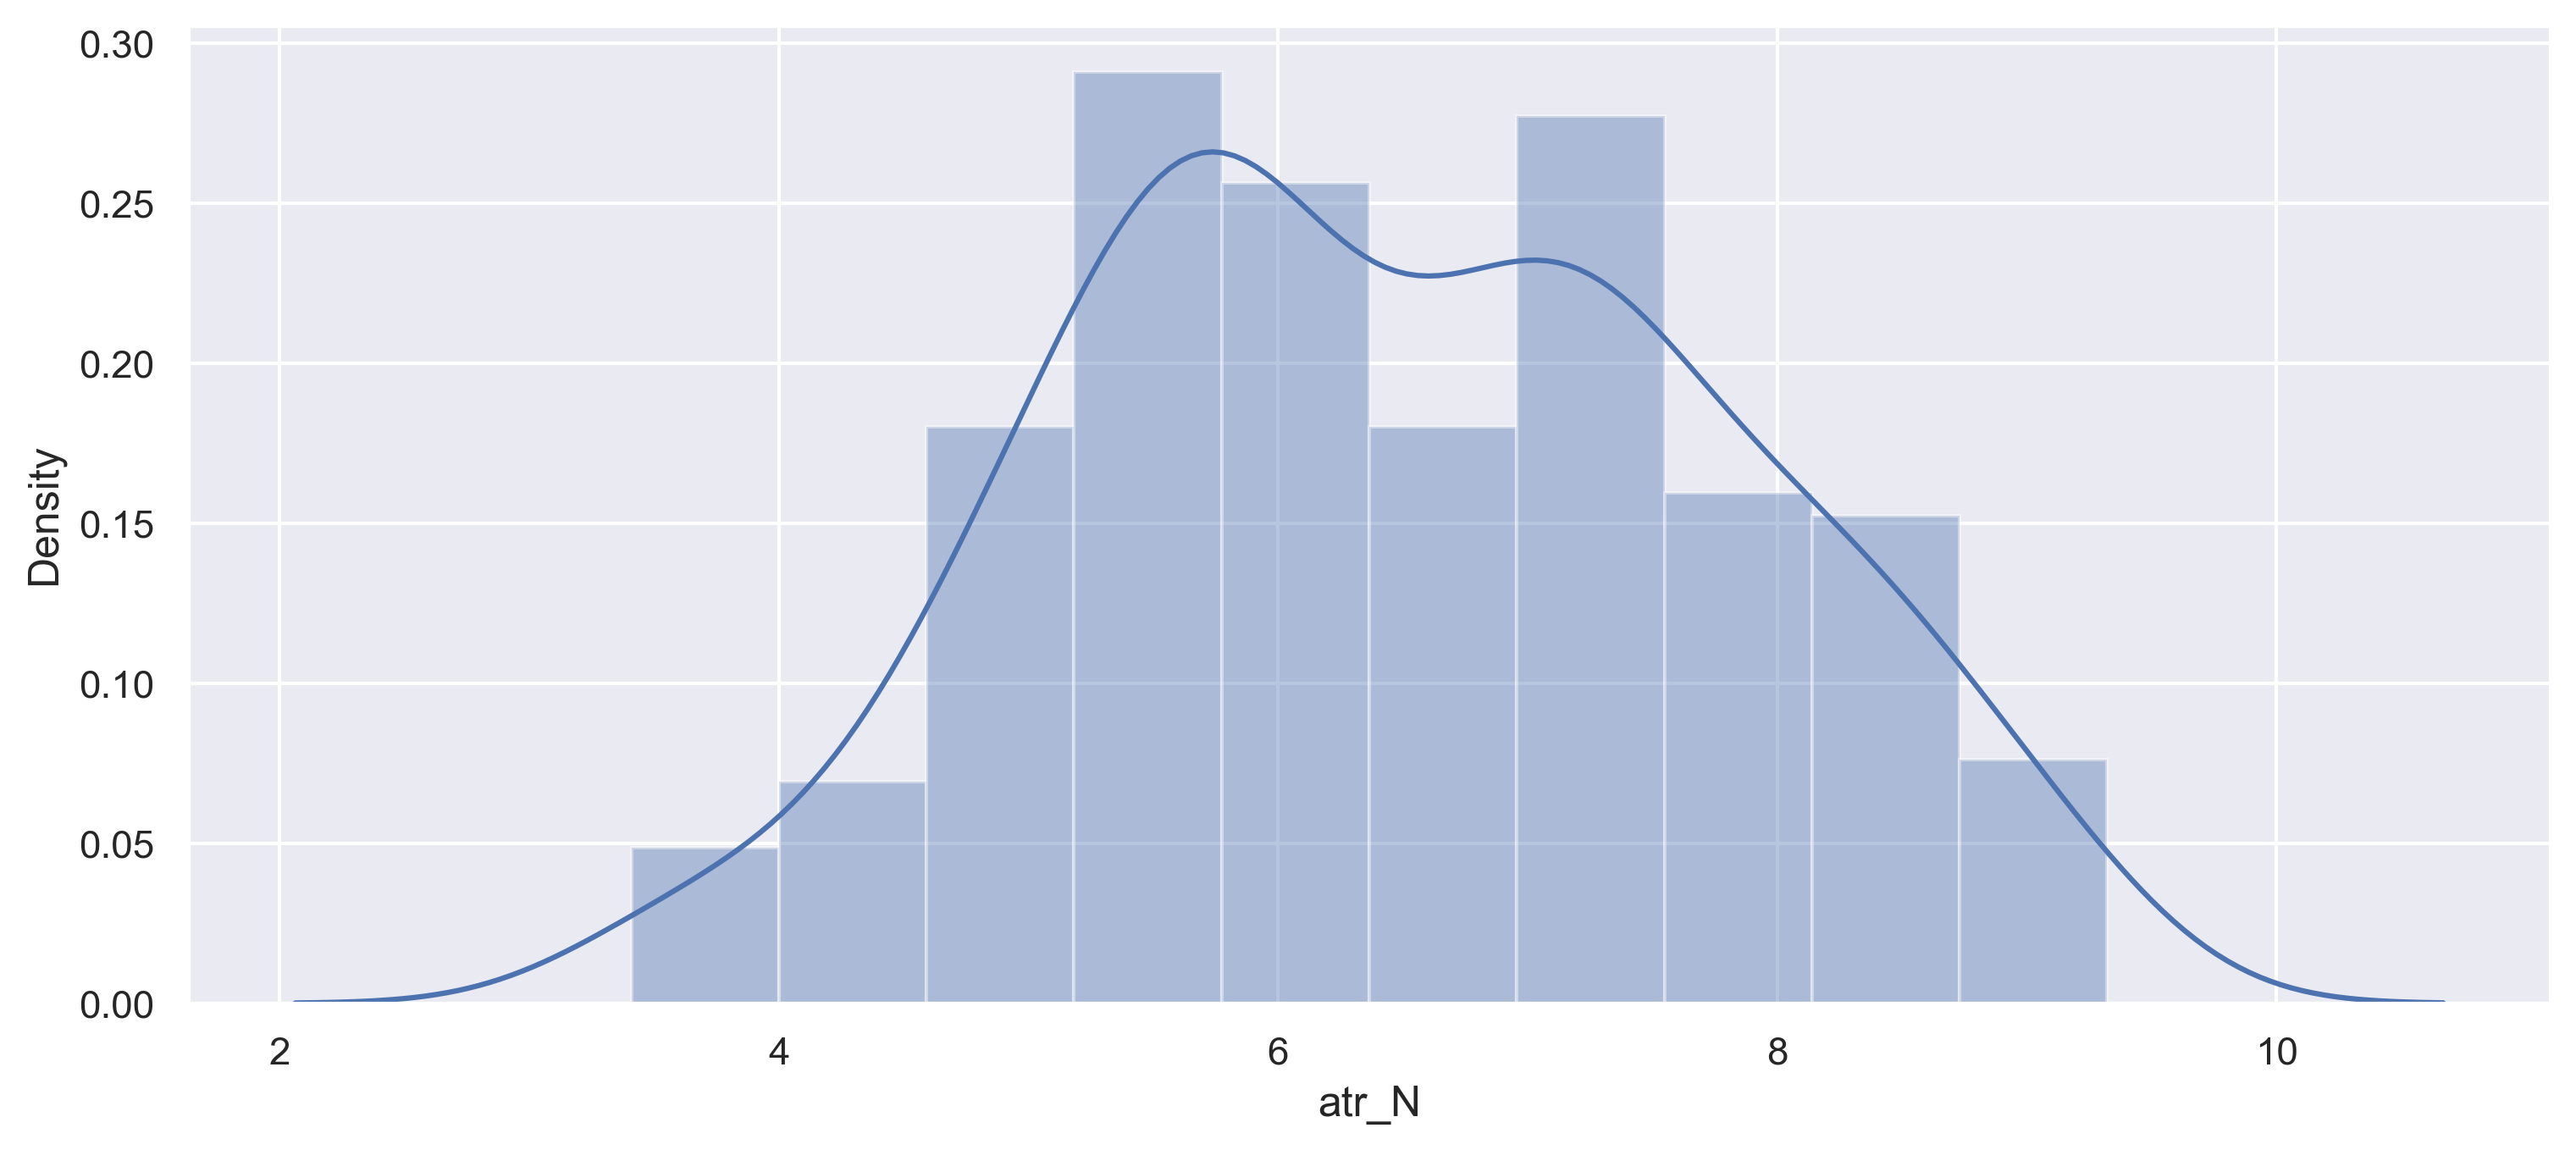

In [630]:
sns.set(rc={"figure.figsize":(12, 5)}) #width=8, height=4
ax = sns.distplot(wdf_H.atr_N)

In [631]:
strategy = 'i-market-segmentation'
strategy_params_json = f'./strategy-params/{strategy}.json'

dlen = len(df_H)
sl_n2= IntSlider(description="n2", min=0, max=ceil(log(dlen, 2.0)+1), step=1, value=9)
sl_w = IntSlider(description="w", min=0, max=ceil(dlen/pow(2,sl_n2.value-1)-1), step=1, value=1)
def update_sl_w_range(*args):
    sl_w.max = ceil(dlen/pow(2,sl_n2.value-1)-1)
sl_n2.observe(update_sl_w_range, 'value')

strategy_params = DotMap(
    atr_H=DotMap(type='IntText', kwargs=DotMap(value=14, step=1)),
    ma1_H=DotMap(type='IntText', kwargs=DotMap(value=14, step=1)),
    ma2_H=DotMap(type='IntText', kwargs=DotMap(value=26, step=1)),
    ma3_H=DotMap(type='IntText', kwargs=DotMap(value=50, step=1)),
    st_L_k=DotMap(type='IntText', kwargs=DotMap(value=14, step=1)),
    atr_F=DotMap(type='FloatRangeSlider', kwargs=DotMap(value=[5,10], step=0.25, min=0, max=20)),
    r2r=DotMap(type='FloatText', kwargs=DotMap(value=2, step=0.1)),
)

for pk, pv in strategy_params.items():
    pv.wdg = globals()[(pv['wdg'] if 'wdg' in pv else pv['type'])](
        description=pk,disabled=False,continuous_update=False, **pv.kwargs
    )
strategy_params = {"w2log": {'wdg': sl_n2}, "w": {'wdg': sl_w}, **strategy_params}
wdgts = [pv['wdg'] for pk, pv in strategy_params.items()]

ui = widgets.VBox([widgets.HBox(wdgts[i:i+4]) for i in range(0, len(wdgts), 4)])

wst = wed = wsz = False
wdf_H = wdf_L = False
fig = gs0  = False

def printer(w2log, w, **kwargs):
    params = DotMap(kwargs)
    # global capital
    capital = 10000
    global wst, wed, wsz, wdf_H, wdf_L
    global fig, gs0
    with open(strategy_params_json, "w") as f: f.write(json.dumps({k: v['wdg'].value for k, v in strategy_params.items()}))

    wsz = floor(pow(2,w2log))
    wst = floor(w * wsz / 2)
    wed = floor(wst + wsz)
    
    ##################################################
    ################ Higher Timeframe ################

    wdf_H = df_H.iloc[wst:wed,:].copy()
    # wdf_H['lret'] = wdf_H.c.apply(np.log).diff()
    
    ### Indicators
    wdf_H['ma1'] = wdf_H.c.ewm(span=params.ma1_H, adjust=False).mean()
    wdf_H['ma2'] = wdf_H.c.ewm(span=params.ma2_H, adjust=False).mean()
    wdf_H['ma3'] = wdf_H.c.ewm(span=params.ma3_H, adjust=False).mean()

    add_atr(wdf_H, params.atr_H)

    ### Filter groups

    cond_in_H = (
        (wdf_H.ma1 > wdf_H.ma2) & 
        (wdf_H.ma2 > wdf_H.ma3)
    )
    cond_out_H = (~cond_in_H)
    

    add_groups(wdf_H, cond_in_H, cond_out_H, prefix='maH_')
    maH_inside = wdf_H[wdf_H.maH_in]
    maH_groups = maH_inside.groupby(['maH_no'])


    #################################################
    ################ Lower Timeframe ################

    wdf_L = df_L.loc[wdf_H.iloc[0].date:wdf_H.iloc[-1].date].copy()
    # wdf_L['lret'] = wdf_L.c.apply(np.log).diff()
    # wlen = len(wdf)

    # ### Indicators
    # wdf_L['ma1'] = wdf_L.c.ewm(span=params.ma1_L, adjust=False).mean()
    # wdf_L['ma2'] = wdf_L.c.ewm(span=params.ma2_L, adjust=False).mean()
    # wdf_L['ma3'] = wdf_L.c.ewm(span=params.ma3_L, adjust=False).mean()

    copy_data_from_H(wdf_L, ['ma1', 'ma2', 'ma3', 'tr_N', 'atr_N', 'maH_no', 'maH_start', 'maH_end', 'maH_in'], wdf_H)

    add_stoch(wdf_L, params.st_L_k, 3)
    # add_atr(wdf_L, params.atr_L)

    df = wdf_L.copy()

    # Volatility and trend
    cond_volatility_low = (df.atr_N_H < params.atr_F[0])
    cond_volatility_mid = ((df.atr_N_H >= params.atr_F[0]) & (df.atr_N_H <= params.atr_F[1]))
    cond_volatility_high = (df.atr_N_H > params.atr_F[1])
    # volatility_cond_arr = [ cond_volatility_low, cond_volatility_mid, cond_volatility_high ]

    cond_trend_up = ( (df.ma1_H > df.ma2_H) & (df.ma2_H > df.ma3_H) )
    cond_trend_dn = ( (df.ma1_H < df.ma2_H) & (df.ma2_H < df.ma3_H) )
    # cond_trend_side = ( (~cond_trend_up) & (~cond_trend_dn))

    # trend_cond_arr = [cond_trend_up, cond_trend_side, cond_trend_dn]
    df['vty'] = np.where(cond_volatility_low, 'vty_low',
      np.where(cond_volatility_high, 'vty_high', 'vty_mid'))

    df['trend'] = np.where(cond_trend_up, 'tnd_up',
      np.where(cond_trend_dn, 'tnd_down', 'tnd_side'))

    # Positions
    sig = (
      (df.stoch_k < 20).shift(fill_value=False) &  
      (df.stoch_k < df.stoch_d).shift(fill_value=False) &
      (df.stoch_k > df.stoch_d)
    )
    df.loc[sig, 'lret'] = 0
    nperiods = 32
    tframe_delta = pd.Timedelta(tframe_L)

    dpfs = [df[start:(start + tframe_delta * nperiods)].copy() for start in df[sig].index]
    # len(dpfs[0])
    for dpf in dpfs:
      dpf['sumret'] = dpf.lret.cumsum()

    pstats = [{
      **{k: dpf.iloc[0][k] for k in ['date', 'trend', 'vty', 'o', 'o_log', 'atr_N_H']},
      # 'date':dpf.iloc[0].date,
      # 'trend': dpf.iloc[0].trend,
      # 'vty': dpf.iloc[0].vty,
      # 'o':dpf.iloc[0].o, 'o_log':dpf.iloc[0].o_log, 
        'c':dpf.iloc[-1].c, 'c_log':dpf.iloc[-1].c_log, 
        'l_min':dpf.l.min(), 'h_max':dpf.h.max(), 
        'l_log_min':dpf.l_log.min(), 'h_log_max':dpf.h_log.max(), 
        'max_c_ret':dpf.sumret.max(), 'min_c_ret':dpf.sumret.min(),
        'c_ret':dpf.iloc[-1].sumret}
      for dpf in dpfs
    ]

    # label for volatility and trend
    stdf = pd.DataFrame.from_dict(pstats)
    stdf.set_index('date', inplace=True)
    stdf['max_downside'] = -(stdf.l_log_min - stdf.o_log)
    stdf['max_upside'] = stdf.h_log_max - stdf.o_log

    stdf['max_downside_atrnh'] = stdf['max_downside'] / stdf['atr_N_H']
    stdf['max_upside_atrnh'] = stdf['max_upside'] / stdf['atr_N_H']
    stdf['r2rd'] = stdf['max_upside'] - params.r2r * stdf['max_downside']

    # atr_F


    # plt.close("all")



    # with plt.rc_context():

      # fig, gs0 = chart_em(chart_groups=[
      #         {
      #             'df': wdf_H.rename(columns={'o':'open','h':'high','l':'low','c':'close'}),
      #             'gkwargs': DotMap(height_ratios=[1], hspace=0.05),
      #             'charts': [
      #                 {   
      #                     'lines':['close'],
      #                     'colors':  ['black'],
                          
      #                 },
      #                 # {
      #                 #     'lines': ['tr_N', 'atr_N'],
      #                 #     'colors': ['orange','blue'],
      #                 # }
      #             ],
      #         },
      # ])

#################
    # g = sns.FacetGrid(stdf, row="trend", col="vty",height=1, aspect=1,
    # subplot_kws={},
    # gridspec_kws={})
    # # g.fig.set_figheight(5)
    # # g.fig.set_figwidth(3)
    # # sns.set(rc={"figure.figsize":(12, 5)}) 
    # # g.despine(bottom=True, left=True)
    # plt.gcf().set_size_inches(12, 5)
    # g.map(sns.scatterplot, "max_downside_atrnh", "max_upside_atrnh", color="#334488", s=3)
    # g.set_axis_labels("downside-atrnh", "upside-atrnh", fontsize=10)

    # for ax in g.axes_dict.values():
    #   ax.axline((0, 0), slope=1, c=".2", ls="-", zorder=0)
    #   ax.axline((0, 0), slope=params.r2r, c=".4", ls="dotted", zorder=0)

#################
    g = sns.FacetGrid(stdf, row="trend", col="vty",height=1, aspect=1,)
    plt.gcf().set_size_inches(12, 5)
    g.map(sns.kdeplot, "r2rd")
#################
      # g.set(xticks=[10, 30, 50], yticks=[2, 6, 10])
      # g.figure.subplots_adjust(wspace=.02, hspace=.02)

      # fig, axs = plt.subplots(nrows=len(volatility_cond_arr), ncols=len(trend_cond_arr), constrained_layout=True, figsize=(12,5))

      # for trend_cond in trend_cond_arr:
      #   for vol_cond in volatility_cond_arr:
      #     cond = (trend_cond & vol_cond)
      #     df = stdf.loc[stdf.index.intersection(cond[cond].index)]

      # gs0 = gridspec.GridSpec(len(trend_cond_arr), len(volatility_cond_arr), figure=fig)
      # for ax in axs.flat:
      #     example_plot(ax)
            
    # plt.show()
    
if exists(strategy_params_json):
    with open(strategy_params_json) as f: 
        js = json.loads(f.read());
        for k, v in strategy_params.items(): 
            if k in js: v['wdg'].value=js[k];
                                        

out = widgets.interactive_output(printer, {k : v['wdg'] for k,v in strategy_params.items()})
display(ui, out)

In [602]:
# len(wdf_L)
wdf_L

,ts,o,h,l,c,v,date,o_log,h_log,l_log,...,tr_N_H,atr_N_H,maH_no_H,maH_start_H,maH_end_H,maH_in_H,n_high,n_low,stoch_k,stoch_d
2021-01-01 00:00:00,1.609459e+12,0.3358,0.3387,0.3328,0.3337,842520.45,2021-01-01 00:00:00,-1.091240,-1.082641,-1.100214,...,4.479769,NaN,0.0,False,False,False,NaN,NaN,NaN,NaN
2021-01-01 00:15:00,1.609460e+12,0.3334,0.3357,0.3326,0.3331,308564.44,2021-01-01 00:15:00,-1.098412,-1.091537,-1.100815,...,4.479769,NaN,0.0,False,False,False,NaN,NaN,NaN,NaN
2021-01-01 00:30:00,1.609461e+12,0.3331,0.3391,0.3310,0.3386,412956.79,2021-01-01 00:30:00,-1.099313,-1.081460,-1.105637,...,4.479769,NaN,0.0,False,False,False,NaN,NaN,NaN,NaN
2021-01-01 00:45:00,1.609462e+12,0.3387,0.3465,0.3376,0.3460,1045978.88,2021-01-01 00:45:00,-1.082641,-1.059872,-1.085894,...,4.479769,NaN,0.0,False,False,False,NaN,NaN,NaN,NaN
2021-01-01 01:00:00,1.609463e+12,0.3460,0.3496,0.3423,0.3434,978420.45,2021-01-01 01:00:00,-1.061317,-1.050966,-1.072068,...,2.872063,NaN,0.0,False,False,False,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-27 06:00:00,1.616825e+12,1.1146,1.1191,1.1105,1.1175,210180.56,2021-03-27 06:00:00,0.108496,0.112525,0.104810,...,0.960589,1.472305,34.0,False,False,True,1.1191,1.0913,94.244604,96.961027
2021-03-27 06:15:00,1.616826e+12,1.1173,1.1212,1.1136,1.1174,189802.66,2021-03-27 06:15:00,0.110915,0.114400,0.107598,...,0.960589,1.472305,34.0,False,False,True,1.1212,1.0913,87.290970,93.008371
2021-03-27 06:30:00,1.616827e+12,1.1174,1.1201,1.1162,1.1170,232312.58,2021-03-27 06:30:00,0.111005,0.113418,0.109930,...,0.960589,1.472305,34.0,False,False,True,1.1212,1.0922,85.517241,89.017605
2021-03-27 06:45:00,1.616828e+12,1.1167,1.1179,1.1120,1.1139,198682.40,2021-03-27 06:45:00,0.110378,0.111452,0.106160,...,0.960589,1.472305,34.0,False,False,True,1.1212,1.0953,71.814672,81.540961


In [ ]:
strategy = 'i-emas-stats'
strategy_params_json = f'./strategy-params/{strategy}.json'

fee:float = 0.001
# capital = 10000
# risk_per_trade_perc = 0.01
# risk = 0.01
ddf = df
dlen = len(ddf)

sl_n2= IntSlider(description="n2", min=0, max=ceil(log(dlen, 2.0)+1), step=1, value=9)
sl_w = IntSlider(description="w", min=0, max=ceil(dlen/pow(2,sl_n2.value-1)-1), step=1, value=1)
def update_sl_w_range(*args):
    sl_w.max = ceil(dlen/pow(2,sl_n2.value-1)-1)
sl_n2.observe(update_sl_w_range, 'value')

strategy_params = {
    # 'mav1': {'type': 'int', 'value': 21, 'step': 1},
    # 'mav2': {'type': 'int', 'value': 50, 'step': 1},
    # 'mav3': {'type': 'int', 'value': 50, 'step': 5},
    # 'mav1mav2': {'type': 'float', 'value': 0.01, 'step': 0.0005},
    # 'mav2mav3': {'type': 'float', 'value': 0.01, 'step': 0.0005},
    # 'stop_gap': {'type': 'float', 'value': 0.001, 'step': 0.0005},
    # 'slipage': {'type': 'float', 'value': 0.001, 'step': 0.0005},
    # 'risk': {'type': 'float', 'value': 0.01, 'step': 0.005},
    # 'sl': {'type': 'float', 'value': 0.01, 'step': 0.001},
    # 'r2r': {'type': 'float', 'value': 2./1., 'step': 0.05},
    # 'wbtp': {'type': 'float', 'value': 0.1, 'step': 0.05},
    # 'trail': {'type': 'float', 'value': 0.02, 'step': 0.005},
}
for pk, pv in strategy_params.items():
    pv['wdg'] = globals()[(pv['wdg'] if 'wdg' in pv else pv['type'].capitalize() + 'Text')](
        description=pk,disabled=False,continuous_update=False,
        value=pv['value'], step=pv['step']
    )
strategy_params = {"w2log": {'wdg': sl_n2}, "w": {'wdg': sl_w}, **strategy_params}
wdgts = [pv['wdg'] for pk, pv in strategy_params.items()]

ui = widgets.VBox([widgets.HBox(wdgts[i:i+4]) for i in range(0, len(wdgts), 4)])

wst = wed = wsz = False
wdf = wadf = False

def printer(w2log, w):
    # global capital
    capital = 10000
    global wst, wed, wsz, wdf
    with open(strategy_params_json, "w") as f: f.write(json.dumps({k: v['wdg'].value for k, v in strategy_params.items()}))

    wsz = floor(pow(2,w2log))
    wst = floor(w * wsz / 2)
    wed = floor(wst + wsz)
    
    wdf = ddf.iloc[wst:wed,:].copy()    
    wlen = len(wdf)

    
    plt.close("all")
    vlines=list(wdf[wdf['g_cond_beg_end']].index.astype('string').values)

    with plt.rc_context():
        kwargs = dict(warn_too_much_data=100000)

        wdf = wdf.rename(columns={'o': 'open', 'h': 'high', 'l': 'low', 'c': 'close'})
        fig = plt.figure(constrained_layout=True,figsize=(16,5))
        gs0 = fig.add_gridspec(1, 2, width_ratios=[3,1])

        gs00 = gs0[0,0].subgridspec(3, 1, height_ratios=[3,1,1])

        ax001 = fig.add_subplot(gs00[0,0])
        ax002 = fig.add_subplot(gs00[1,0], sharex=ax001)
        ax003 = fig.add_subplot(gs00[2,0], sharex=ax001)

        # gs01 = gs0[0,1].subgridspec(4, 1)
        # ax101 = fig.add_subplot(gs01[0,0])
        # ax102 = fig.add_subplot(gs01[1,0])
        # ax103 = fig.add_subplot(gs01[2,0])
        
        locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
        formatter = mdates.ConciseDateFormatter(locator)
        ax001.xaxis.set_major_locator(locator)
        ax001.xaxis.set_major_formatter(formatter)

        mpf.plot(wdf,
            **{**kwargs, **dict(volume=False, style='binance',type='candle')},  #figsize=(15, 5)
            show_nontrading=True,
            vlines=dict(vlines=vlines, linewidths=(1,0.5), colors=('g','c'), linestyle='-.'),
            ax=ax001,
            # vlines=['2021-03-15 04:00:00'],
            # addplot=ap2
            )
        ax001.plot(wdf.ma1, color='orange')
        ax001.plot(wdf.ma2, color='green')
        ax001.plot(wdf.ma3, color='blue')
        
        max_in_lret = wdf[['inlret', 'r_inlret']].max().max()
        min_in_lret = wdf[['inlret', 'r_inlret']].min().min()
        ax002.plot(wdf.r_inlret, lw=1, color='r')
        ax002.plot(wdf.max_r_inlret, lw=1, color='g', linestyle='dashed')
        ax002.plot(wdf.min_r_inlret, lw=1, color='r', linestyle='dashed')
        ax002.vlines(wdf[wdf.g_cond_beg_end].index, min_in_lret, max_in_lret, lw=0.5, color="c")

        ax003.plot(wdf.fair_c_ma2, lw=1, color='g')
       
    plt.show()
    
if exists(strategy_params_json):
    with open(strategy_params_json) as f: 
        js = json.loads(f.read());
        for k, v in strategy_params.items(): 
            if k in js: v['wdg'].value=js[k];
                                        

out = widgets.interactive_output(printer, {k : v['wdg'] for k,v in strategy_params.items()})
display(ui, out)

In [ ]:
df['lo'] = df.o.apply(np.log)
df['lh'] = df.h.apply(np.log)
df['ll'] = df.l.apply(np.log)
df['lc'] = df.c.apply(np.log)

df['ma1'] = df.c.ewm(span=14, adjust=False).mean()
df['ma2'] = df.c.ewm(span=26, adjust=False).mean()
df['ma3'] = df.c.ewm(span=50, adjust=False).mean()

df['lma1'] = df.lc.ewm(span=14, adjust=False).mean()
df['lma2'] = df.lc.ewm(span=26, adjust=False).mean()
df['lma3'] = df.lc.ewm(span=50, adjust=False).mean()


df['fair_c_ma1'] = df.lc - df.lma1
df['fair_c_ma2'] = df.lc - df.lma2
df['fair_c_ma3'] = df.lc - df.lma3

df['fair_ma1_ma2'] = df.lma1 - df.lma2
df['fair_ma2_ma3'] = df.lma2 - df.lma3
df['fair_ma1_ma3'] = df.lma1 - df.lma3

df['lret'] = df.c.apply(np.log).diff()
df = df.tail(-50).copy()

In [ ]:
cond_mav_above = (df.lma2 > df.lma3)
cond_mav_below = (df.lma2 <= df.lma3)
# df['lma23_cross_up'] 
cond_beg = ( cond_mav_above & cond_mav_below.shift(fill_value=False) )
g_beg = cond_beg.cumsum()
# df['lma23_cross_dn']
cond_end = ( (g_beg > 0) & cond_mav_below & cond_mav_above.shift(fill_value=False) )

g_beg = cond_beg.cumsum()
g_end = cond_end.cumsum()
g_inside = (g_beg > g_end)
df['g_beg'] = g_beg
df['g_end'] = g_end
df['g_cond_beg_end'] = (cond_beg | cond_end)
df['g_inside'] = g_inside 
df_inside = df[g_inside].copy()

pos_groups = df_inside.groupby(['g_beg'])
df_inside.loc[pos_groups.head(1).index, 'lret'] = 0.
df_inside['inlret'] = pos_groups['lret'].cumsum(axis=0)
r_pos_groups = df_inside[::-1].groupby(['g_beg'])
df_inside['r_inlret'] = r_pos_groups['lret'].cumsum(axis=0)[::-1]

r_df_inside = df_inside[::-1]
r_pos_groups = r_df_inside.groupby(['g_beg'])
df_inside['max_r_inlret'] = r_pos_groups['r_inlret'].cummax(axis=0)[::-1]
df_inside['min_r_inlret'] = r_pos_groups['r_inlret'].cummin(axis=0)[::-1]
# df_inside['r_inlret'] =  pos_groups['lret'].transform(lambda x: x[::-1].cumsum()[::-1])
# df_inside['r_inlret'] = pos_groups['lret'][::-1].cumsum(axis=0)[::-1]

df.loc[g_inside, 'inlret'] = df_inside['inlret']
df.loc[g_inside, 'r_inlret'] = df_inside['r_inlret']
df.loc[g_inside, 'max_r_inlret'] = df_inside['max_r_inlret']
df.loc[g_inside, 'min_r_inlret'] = df_inside['min_r_inlret']



In [ ]:
df_inside = df[g_inside].copy()
# sns.set(rc={"figure.figsize":(3, 4)})
# plt.figure(figsize=(12, 2))
# sns.set(rc={'figure.figsize':(11.7,8.27)})
# plt.figure(figsize=(15,4))
# sns.displot(ret_r2r, bins=100)
# sns.displot(max_rets, bins=100)
# sns.displot(min_rets, bins=100)
# sns.displot(df_inside, x="fair_c_ma2", y="max_r_inlret", kind="kde")

# sns.displot(df_inside, x="fair_c_ma2", y="max_r_inlret", binwidth=(0.005, .01), cbar=True)
# sns.displot(df_inside, x="fair_ma2_ma3", y="max_r_inlret", binwidth=(0.005, .01), cbar=True)

sns.jointplot(data=df_inside, x="fair_c_ma2", y="max_r_inlret", marker="+")
plt.gcf().set_size_inches(8, 2)
# ret_r2r

In [ ]:

# sns.displot(df_inside, x="fair_c_ma2", y="min_r_inlret", binwidth=(0.005, .01), cbar=True)
sns.displot(df_inside, x="fair_c_ma2", y="min_r_inlret", binwidth=(0.005, .01), cbar=True)
# sns.jointplot(data=df_inside, x="fair_c_ma2", y="min_r_inlret")

# sns.jointplot(data=df_inside, x="fair_c_ma1", y="min_r_inlret", marker="+")
plt.gcf().set_size_inches(8, 2)

In [ ]:
wdf[['inlret', 'r_inlret']].max().max()

In [ ]:
# df['mdate'] = [mdates.date2num(d) for d in df['date']]
wdf['mdate'] = wdf.date.apply(mdates.date2num)
# pd.to_datetime(wdf['date'], unit='s')